In [48]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from scipy import stats
from ast import literal_eval
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
# Tải dữ liệu từ nltk
nltk.download('punkt')
import warnings; warnings.simplefilter('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HELLO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Tải tệp excel lên
df = pd.read_csv(r"D:\projects\Recommendation_Movie\Data_csv\Raw_Anime.csv")
#Hiển thị 5 dòng đầu
df.head(5)

,title,view,vote,describe,information,img,link_title,listlink
0,Tiểu Lam và Tiểu Lục 3,8.681,1.6,Phần 3 của Tiểu Lam Và Tiểu Lục,Tập mới:060504 Trạng thái: Phim đang chiếu/Cập...,https://cdn.animevietsub.fan/data/poster/2023/...,https://animevietsub.fan/phim/tieu-lam-va-tieu...,https://animevietsub.fan/anime-bo/
1,Thất Hầu Bút Lục,2.495,5.0,"Hai nghìn năm trước, một hậu duệ của Gia tộc Y...",Tập mới:030201 Trạng thái: Phim đang chiếu/Cập...,https://cdn.myanimelist.net/images/anime/1831/...,https://animevietsub.fan/phim/that-hau-but-luc...,https://animevietsub.fan/anime-bo/
2,Kiếm Vực Phong Vân,"1,247,603",7.7,"Trên Kiếm vực đại lục xa xưa, có mười thanh ki...",Tập mới:999897 Trạng thái: Tập 99 Thể loại: An...,https://cdn.animevietsub.fan/data/poster/2021/...,https://animevietsub.fan/phim/kiem-vuc-phong-v...,https://animevietsub.fan/anime-bo/
3,Cửu Thiên Huyền Đế Quyết,"1,773,588",4.7,Tương truyền Huyền Đế tạo ra Cửu Thiên Huyền Đ...,Tập mới:195194193 Trạng thái: Phim đang chiếu/...,https://cdn.animevietsub.fan/data/poster/2021/...,https://animevietsub.fan/phim/cuu-thien-huyen-...,https://animevietsub.fan/anime-bo/
4,Ngạo Thế Cửu Trùng Thiên,182.044,9.8,Vì nắm giữ thần vật Cửu Kiếp kiếm của đại lục ...,Tập mới:080706 Trạng thái: Phim đang chiếu/Cập...,https://cdn.animevietsub.fan/data/poster/2023/...,https://animevietsub.fan/phim/ngao-the-cuu-tru...,https://animevietsub.fan/anime-bo/


In [3]:
# Thông tin dữ liệu
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18139 entries, 0 to 18138
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   title        18139 non-null  object 
 1   view         18139 non-null  object 
 2   vote         18139 non-null  float64
 3   describe     17753 non-null  object 
 4   information  17122 non-null  object 
 5   img          18139 non-null  object 
 6   link_title   18139 non-null  object 
 7   listlink     18139 non-null  object 
dtypes: float64(1), object(7)
memory usage: 1.1+ MB


In [4]:
# Kiểm tra giá trị null
df.isnull().sum()

title             0
view              0
vote              0
describe        386
information    1017
img               0
link_title        0
listlink          0
dtype: int64

In [5]:
# Kiểm tra dữ liệu trùng lặp 
df.duplicated().sum()

1552

In [6]:
# Xóa các dấu phẩy và dấy chấm chuyển cột 'view' thành kiểu int
df['view'] = df['view'].str.replace(',', '').str.replace('.', '').astype(int)

# Kiểm tra kiểu dữ liệu sau khi chuyển đổi
df.dtypes['view']

dtype('int32')

In [7]:
# Xóa các giá trị trùng lặp
df = df.drop_duplicates()

In [8]:
# Kiểm tra dữ liệu trùng lặp 
df.duplicated().sum()

0

In [9]:
# Xóa các giá trị null trong cột 'describe' và 'information'
df.dropna(subset=['describe', 'information'], inplace=True)


In [10]:
# Kiểm tra lại giá trị null
df.isnull().sum()

title          0
view           0
vote           0
describe       0
information    0
img            0
link_title     0
listlink       0
dtype: int64

Tách cột information thành các cột khác theo thông tin

In [11]:
# Copy lại bộ dữ liêu df
data = df.copy()

In [12]:
# Tách cột information thành các cột khác theo thông tin

# Các từ khóa cần tìm
keywords = ['Tập mới', 'Trạng thái', 'Thể loại', 'Đạo diễn', 'Quốc gia', 'Số người theo dõi', 'Thời lượng', 'Chất lượng', 'Rating', 'Ngôn ngữ', 'Studio', 'Season']

# Hàm trích xuất dữ liệu
def extract_keyword_data(information, keyword):
    if isinstance(information, str):
        # Tìm data cho từ khóa hiện tại
        current_data_match = re.search(f'{keyword}:(.*?)(?=(?:{ "|".join(keywords) }):|$)', information)
        if current_data_match:
            # Trích xuất dữ liệu không có từ khóa
            current_data = current_data_match.group(1).strip()
            
            if ',' in current_data:
                # Chuyển đổi thành danh sách các giá trị nếu có dấu phẩy
                return current_data.split(', ')
            else:
                # Chuyển đổi thành chuỗi (str) nếu không có dấu phẩy
                return current_data

# Áp dụng hàm trích xuất cho từng từ khóa
for keyword in keywords:
    data[keyword.lower()] = data['information'].apply(lambda x: extract_keyword_data(x, keyword))

# Xóa cột 'information'
data.drop(columns=['information'], inplace=True)

# Chuyển đổi danh sách chỉ chứa một phần tử thành chuỗi (str)
for keyword in keywords:
    data[keyword.lower()] = data[keyword.lower()].apply(lambda x: x[0] if isinstance(x, list) and len(x) == 1 else x)

# Chuyển tất cả các giá trị thành kiểu dữ liệu chuỗi (str)
data = data.astype(str)
data.head(5)

,title,view,vote,describe,img,link_title,listlink,tập mới,trạng thái,thể loại,đạo diễn,quốc gia,số người theo dõi,thời lượng,chất lượng,rating,ngôn ngữ,studio,season
0,Tiểu Lam và Tiểu Lục 3,8681,1.6,Phần 3 của Tiểu Lam Và Tiểu Lục,https://cdn.animevietsub.fan/data/poster/2023/...,https://animevietsub.fan/phim/tieu-lam-va-tieu...,https://animevietsub.fan/anime-bo/,060504,Phim đang chiếu/Cập Nhật Tập 06 VietSub,"['Anime bộ', 'Fantasy', 'Drama', 'Comedy,']",,"Trung Quốc,",7,06/??,HD,PG-13 - Teens 13 tuổi trở lên,VietSub,"['None found', 'add some']",Mùa Xuân - 2023
1,Thất Hầu Bút Lục,2495,5.0,"Hai nghìn năm trước, một hậu duệ của Gia tộc Y...",https://cdn.myanimelist.net/images/anime/1831/...,https://animevietsub.fan/phim/that-hau-but-luc...,https://animevietsub.fan/anime-bo/,030201,Phim đang chiếu/Cập Nhật Tập 03 VietSub,"['Anime bộ', 'Fantasy', 'Adventure', 'Historic...",,"Trung Quốc,",25,03/12,HD,PG-13 - Teens 13 tuổi trở lên,VietSub,L²Studio,Mùa Xuân - 2023
2,Kiếm Vực Phong Vân,1247603,7.7,"Trên Kiếm vực đại lục xa xưa, có mười thanh ki...",https://cdn.animevietsub.fan/data/poster/2021/...,https://animevietsub.fan/phim/kiem-vuc-phong-v...,https://animevietsub.fan/anime-bo/,999897,Tập 99,"['Anime bộ', 'Fantasy', 'Adventure', 'Martial ...",,"Trung Quốc,","1,417",99/??,HD,PG-13 - Teens 13 tuổi trở lên,VietSub,Ruo Hong Culture,Mùa Thu - 2021
3,Cửu Thiên Huyền Đế Quyết,1773588,4.7,Tương truyền Huyền Đế tạo ra Cửu Thiên Huyền Đ...,https://cdn.animevietsub.fan/data/poster/2021/...,https://animevietsub.fan/phim/cuu-thien-huyen-...,https://animevietsub.fan/anime-bo/,195194193,Phim đang chiếu/Cập Nhật Tập 195 VietSub,"['Anime bộ', 'Action,']",,"Trung Quốc,","2,077",195/??,HD,None,VietSub,Đang Cập Nhập,Mùa Thu - 2021
4,Ngạo Thế Cửu Trùng Thiên,182044,9.8,Vì nắm giữ thần vật Cửu Kiếp kiếm của đại lục ...,https://cdn.animevietsub.fan/data/poster/2023/...,https://animevietsub.fan/phim/ngao-the-cuu-tru...,https://animevietsub.fan/anime-bo/,080706,Phim đang chiếu/Cập Nhật Tập 08 VietSub,"['Anime bộ', 'Cartoon,']",,"Trung Quốc,",214,08/??,HD,PG-13 - Teens 13 tuổi trở lên,VietSub,None,Mùa Xuân - 2023


In [13]:
# Xóa cột không mang ý nghĩa
data = data.drop(columns=["img","link_title", "listlink","tập mới","trạng thái","đạo diễn","thời lượng","chất lượng","ngôn ngữ","studio"])

In [14]:
# Đổi tên các cột 
data = data.rename(columns={'thể loại': 'movie_genre', 'quốc gia': 'nation', 'số người theo dõi': 'follower'})

In [15]:
data.head()

,title,view,vote,describe,movie_genre,nation,follower,rating,season
0,Tiểu Lam và Tiểu Lục 3,8681,1.6,Phần 3 của Tiểu Lam Và Tiểu Lục,"['Anime bộ', 'Fantasy', 'Drama', 'Comedy,']","Trung Quốc,",7,PG-13 - Teens 13 tuổi trở lên,Mùa Xuân - 2023
1,Thất Hầu Bút Lục,2495,5.0,"Hai nghìn năm trước, một hậu duệ của Gia tộc Y...","['Anime bộ', 'Fantasy', 'Adventure', 'Historic...","Trung Quốc,",25,PG-13 - Teens 13 tuổi trở lên,Mùa Xuân - 2023
2,Kiếm Vực Phong Vân,1247603,7.7,"Trên Kiếm vực đại lục xa xưa, có mười thanh ki...","['Anime bộ', 'Fantasy', 'Adventure', 'Martial ...","Trung Quốc,","1,417",PG-13 - Teens 13 tuổi trở lên,Mùa Thu - 2021
3,Cửu Thiên Huyền Đế Quyết,1773588,4.7,Tương truyền Huyền Đế tạo ra Cửu Thiên Huyền Đ...,"['Anime bộ', 'Action,']","Trung Quốc,","2,077",None,Mùa Thu - 2021
4,Ngạo Thế Cửu Trùng Thiên,182044,9.8,Vì nắm giữ thần vật Cửu Kiếp kiếm của đại lục ...,"['Anime bộ', 'Cartoon,']","Trung Quốc,",214,PG-13 - Teens 13 tuổi trở lên,Mùa Xuân - 2023


In [16]:
data.shape

(15462, 9)

In [17]:
# Kiểm tra giá trị null
data.isnull().sum()

title          0
view           0
vote           0
describe       0
movie_genre    0
nation         0
follower       0
rating         0
season         0
dtype: int64

In [18]:
data.describe()

,title,view,vote,describe,movie_genre,nation,follower,rating,season
count,15462,15462,15462,15462,15462,15462,15462,15462,15462
unique,4867,10046,82,4861,2517,7,1791,19,178
top,Cuộc Sống Chậm Của Chiến Binh Hắc Ám Bị Cho Về...,11104,9.6,Được Quân đoàn của Quỷ vương cưu mang và nuôi ...,"['Anime bộ', 'Slice of Life', 'Comedy,']","Nhật Bản,",0,PG-13 - Teens 13 tuổi trở lên,Mùa Xuân - 2023
freq,13,12,1058,13,167,14318,397,9503,443


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15462 entries, 0 to 18138
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        15462 non-null  object
 1   view         15462 non-null  object
 2   vote         15462 non-null  object
 3   describe     15462 non-null  object
 4   movie_genre  15462 non-null  object
 5   nation       15462 non-null  object
 6   follower     15462 non-null  object
 7   rating       15462 non-null  object
 8   season       15462 non-null  object
dtypes: object(9)
memory usage: 1.2+ MB


In [20]:
# Cột season chỉ lấy giá trị là số
data['season'] = data['season'].str.extract('(\d{4})')
data['season'].head()

0    2023
1    2023
2    2021
3    2021
4    2023
Name: season, dtype: object

In [21]:
# Xóa năm 2099 trong cột ‘season’
data = data[data['season'] != 2099]

In [22]:
# Xóa giá trị trùng lặp trong cột "title"
data = data.drop_duplicates(subset='title', keep='first')

In [23]:
data.shape

(4867, 9)

In [24]:
# Chuyển tất cả các giá trị trong dataframe thành chữ thường
data = data.apply(lambda x: x.astype(str).str.lower() if x.dtype == 'object' else x)


In [25]:
# Kiểm tra kiểu dữ liệu của cột "follower" và chuyển đổi thành chuỗi nếu cần thiết
if data['follower'].dtype != 'object':
    data['follower'] = data['follower'].astype(str)

# Loại bỏ dấu chấm trong cột "follower"
data['follower'] = data['follower'].str.replace(',', '')

In [26]:
# Loại bỏ dấu phẩy trong cột "nation"
data['nation'] = data['nation'].str.replace(',', '')

In [27]:
data.head()

,title,view,vote,describe,movie_genre,nation,follower,rating,season
0,tiểu lam và tiểu lục 3,8681,1.6,phần 3 của tiểu lam và tiểu lục,"['anime bộ', 'fantasy', 'drama', 'comedy,']",trung quốc,7,pg-13 - teens 13 tuổi trở lên,2023
1,thất hầu bút lục,2495,5.0,"hai nghìn năm trước, một hậu duệ của gia tộc y...","['anime bộ', 'fantasy', 'adventure', 'historic...",trung quốc,25,pg-13 - teens 13 tuổi trở lên,2023
2,kiếm vực phong vân,1247603,7.7,"trên kiếm vực đại lục xa xưa, có mười thanh ki...","['anime bộ', 'fantasy', 'adventure', 'martial ...",trung quốc,1417,pg-13 - teens 13 tuổi trở lên,2021
3,cửu thiên huyền đế quyết,1773588,4.7,tương truyền huyền đế tạo ra cửu thiên huyền đ...,"['anime bộ', 'action,']",trung quốc,2077,none,2021
4,ngạo thế cửu trùng thiên,182044,9.8,vì nắm giữ thần vật cửu kiếp kiếm của đại lục ...,"['anime bộ', 'cartoon,']",trung quốc,214,pg-13 - teens 13 tuổi trở lên,2023


Xử lý dữ liệu

In [28]:
anime_data = data.copy()

In [29]:
# Bộ Vietnamese stopwords
vietnamese_stopwords = set([
    'cả', 'các', 'cần', 'càng', 'chỉ', 'chiếc', 'cho', 'chứ', 'chưa', 'chuyện', 'có', 'có_thể', 'cứ', 'của', 
    'cùng', 'cũng', 'đã', 'đang', 'đây', 'để', 'đến_nỗi', 'đều', 'điều', 'do', 'đó', 'được', 'dưới', 'gì', 
    'khi', 'không', 'là', 'lại', 'lên', 'lúc', 'mà', 'mỗi', 'một_cách', 'này', 'nên', 'nếu', 'ngay', 'nhiều', 
    'như', 'nhưng', 'những', 'nơi', 'nữa', 'phải', 'qua', 'ra', 'rằng', 'rất', 'rồi', 'sau', 'sẽ', 'so', 
    'sự', 'tại', 'theo', 'thì', 'trên', 'trước', 'từ', 'từng', 'và', 'vẫn', 'vào', 'vậy', 'vì', 'việc', 'với', 
    'vừa', 'hơn','một','phần','nắm','cuộc','bị','mùa','thứ','một','về','hai','ba','bốn','năm','sáu','bảy','tám',
    'chín','mười'
])

In [30]:
def preprocess_text(text):

    # Loại bỏ các ký tự đặc biệt
    text = re.sub(r'[!@#$%^&*)(";:|\/><.,-_]', '', text)
    # Tách thành từng từ
    words = text.split()
    # Loại bỏ từ dừng
    words = [word for word in words if word not in vietnamese_stopwords]
    # Ghép các từ lại thành câu
    return ' '.join(words)

# Loại bỏ các ký tự đặc biệt cho cột 'describe'
anime_data['describe'] = anime_data['describe'].apply(preprocess_text)

In [31]:
anime_data['describe'].head()

0                                    tiểu lam tiểu lục
1    nghìn hậu duệ gia tộc yinyang cảm thấy đau buồ...
2    kiếm vực đại lục xa xưa thanh kiếm thần đại gi...
3    tương truyền huyền đế tạo cửu thiên huyền đế q...
4    giữ thần vật cửu kiếp kiếm đại lục cửu trùng t...
Name: describe, dtype: object

In [32]:
anime_data['movie_genre'].head()

0          ['anime bộ', 'fantasy', 'drama', 'comedy,']
1    ['anime bộ', 'fantasy', 'adventure', 'historic...
2    ['anime bộ', 'fantasy', 'adventure', 'martial ...
3                              ['anime bộ', 'action,']
4                             ['anime bộ', 'cartoon,']
Name: movie_genre, dtype: object

In [33]:
anime_data['nation'].head()

0    trung quốc
1    trung quốc
2    trung quốc
3    trung quốc
4    trung quốc
Name: nation, dtype: object

In [34]:
# Hàm được sửa đổi để xử lý các giá trị không phải chuỗi trong 'movie_genre'
def normalize_and_tokenize_genres_v2(genre_text):
    if not isinstance(genre_text, str):
        return []

    # Xóa dấu ngoặc và dấu ngoặc kép
    genre_text = genre_text.replace("[", "").replace("]", "").replace("'", "").replace('"', '')
    # Chia bằng dấu phẩy
    genres = genre_text.split(',')
    # Chuẩn hóa (cắt và thay thế dấu cách bằng dấu gạch dưới trong các từ ghép)
    normalized_genres = [genre.strip().replace(' ', '_') for genre in genres]
    return normalized_genres

# Áp dụng chức năng đã sửa đổi cho cột 'movie_genre'
anime_data['movie_genre'] = anime_data['movie_genre'].apply(normalize_and_tokenize_genres_v2)

# Hiển thị
anime_data['movie_genre'].head(20)


0                  [anime_bộ, fantasy, drama, comedy, ]
1     [anime_bộ, fantasy, adventure, historical, mar...
2     [anime_bộ, fantasy, adventure, martial_arts, a...
3                                  [anime_bộ, action, ]
4                                 [anime_bộ, cartoon, ]
5                    [anime_bộ, martial_arts, action, ]
6                        [anime_bộ, cartoon, fantasy, ]
7                                  [anime_bộ, action, ]
8     [anime_bộ, supernatural, adventure, magic, act...
9     [anime_bộ, cartoon, fantasy, adventure, martia...
10          [anime_bộ, shounen, supernatural, horror, ]
11                         [anime_bộ, seinen, sports, ]
12    [anime_bộ, slice_of_life, school, romance, har...
13                                 [anime_bộ, sports, ]
14    [anime_bộ, seinen, supernatural, romance, psyc...
15    [anime_bộ, slice_of_life, shoujo, supernatural...
16                        [anime_bộ, shounen, sports, ]
17    [anime_bộ, shounen, game, fantasy, adventu

In [35]:
# Sử dụng thư viện Underthesea cho tiếng Việt để tách từ
from underthesea import word_tokenize
# Áp dụng hàm word_tokenize cho mỗi dòng của cột 'describe'
anime_data['describe'] = anime_data['describe'].apply(lambda x: word_tokenize(x, format="text"))
anime_data['describe'].head()

0                                    tiểu_lam tiểu_lục
1    nghìn hậu_duệ gia_tộc yinyang cảm_thấy đau_buồ...
2    kiếm vực đại_lục xa_xưa thanh kiếm thần đại_gi...
3    tương_truyền huyền_đế tạo cửu_thiên huyền_đế q...
4    giữ thần_vật cửu_kiếp kiếm đại_lục_cửu trùng_t...
Name: describe, dtype: object

In [36]:
# Áp dụng hàm word_tokenize cho mỗi dòng của cột 'nation'
anime_data['nation'] = anime_data['nation'].apply(lambda x: word_tokenize(x, format="text"))
anime_data['nation'].head()

0    trung_quốc
1    trung_quốc
2    trung_quốc
3    trung_quốc
4    trung_quốc
Name: nation, dtype: object

In [37]:
# Lưu dữ liệu vào tệp CSV "animeclear.csv"
anime_data.to_csv(r"D:\projects\Recommendation_Movie\Data_csv\Anime_TXL.csv", index=False, encoding='utf-8-sig')


Tiến hành gộp cái cột dữ liệu

In [38]:
# Tải tệp csv lên
file_path = r"D:\projects\Recommendation_Movie\Data_csv\Anime_TXL.csv"
anime_data = pd.read_csv(file_path)
anime_data.head(5)

,title,view,vote,describe,movie_genre,nation,follower,rating,season
0,tiểu lam và tiểu lục 3,8681,1.6,tiểu_lam tiểu_lục,"['anime_bộ', 'fantasy', 'drama', 'comedy', '']",trung_quốc,7,pg-13 - teens 13 tuổi trở lên,2023.0
1,thất hầu bút lục,2495,5.0,nghìn hậu_duệ gia_tộc yinyang cảm_thấy đau_buồ...,"['anime_bộ', 'fantasy', 'adventure', 'historic...",trung_quốc,25,pg-13 - teens 13 tuổi trở lên,2023.0
2,kiếm vực phong vân,1247603,7.7,kiếm vực đại_lục xa_xưa thanh kiếm thần đại_gi...,"['anime_bộ', 'fantasy', 'adventure', 'martial_...",trung_quốc,1417,pg-13 - teens 13 tuổi trở lên,2021.0
3,cửu thiên huyền đế quyết,1773588,4.7,tương_truyền huyền_đế tạo cửu_thiên huyền_đế q...,"['anime_bộ', 'action', '']",trung_quốc,2077,none,2021.0
4,ngạo thế cửu trùng thiên,182044,9.8,giữ thần_vật cửu_kiếp kiếm đại_lục_cửu trùng_t...,"['anime_bộ', 'cartoon', '']",trung_quốc,214,pg-13 - teens 13 tuổi trở lên,2023.0


In [39]:
# Xóa các hàng có giá trị NaN trong tất cả các cột
anime_data.dropna(inplace=True)

In [40]:
import ast
# Chuyển đổi chuỗi thành danh sách Python và sau đó xử lý cột 'movie_genre'
anime_data['movie_genre'] = anime_data['movie_genre'].apply(lambda x: ' '.join(filter(None, ast.literal_eval(x))))

# In ra DataFrame sau khi xử lý
anime_data['movie_genre'].head()

0                        anime_bộ fantasy drama comedy
1    anime_bộ fantasy adventure historical martial_...
2       anime_bộ fantasy adventure martial_arts action
3                                      anime_bộ action
4                                     anime_bộ cartoon
Name: movie_genre, dtype: object

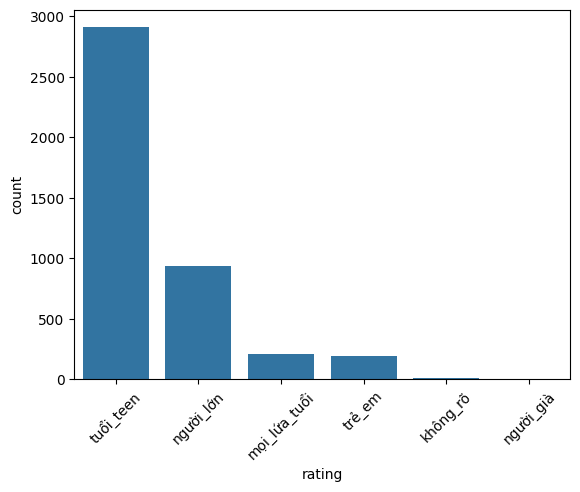

In [41]:
# Tạo một ánh xạ (mapping) từ các rating hiện có đến các nhóm tương ứng
rating_mapping = {
    'pg-13 - teens 13 tuổi trở lên': 'tuổi_teen',
    'không rõ': 'không_rõ',
    'r - 17+ (bạo lực và tục tĩu)': 'người_lớn',
    'g - mọi lứa tuổi': 'mọi_lứa_tuổi',
    'pg - trẻ em': 'trẻ_em',
    'r+ - dành cho 16 tuổi trở lên': 'người_lớn',
    'pg-13': 'tuổi_teen',
    'nona': 'không_rõ',
    'đang cập nhập': 'không_rõ',
    'rx - hentai': 'người_lớn',
    'r + - ảnh khỏa thân nhẹ': 'người_lớn',
    '13+ - teens 13 or older': 'tuổi_teen',
    'r+ 17': 'người_lớn',
    'pg - children': 'trẻ_em',
    'r+ - dành cho 69 tuổi trở lên': 'người_già',
    'undefined': 'không_rõ'
}

# Ánh xạ các giá trị trong cột 'rating' bằng cách sử dụng ánh xạ đã tạo
anime_data['rating'] = anime_data['rating'].map(rating_mapping)

# Vẽ biểu đồ phân phối của các nhóm rating
sns.countplot(data=anime_data, x='rating', order=anime_data['rating'].value_counts().index)
plt.xticks(rotation=45)
plt.show()

In [42]:
df = anime_data.copy()

In [43]:
# Tích gộp các cột lại để khởi tạo mô hình
df['combined_text'] = df['describe'] + ' ' + df['movie_genre'] + ' ' + df['nation'] + ' ' + df['rating'].astype(str)


In [44]:
df.head()

,title,view,vote,describe,movie_genre,nation,follower,rating,season,combined_text
0,tiểu lam và tiểu lục 3,8681,1.6,tiểu_lam tiểu_lục,anime_bộ fantasy drama comedy,trung_quốc,7,tuổi_teen,2023.0,tiểu_lam tiểu_lục anime_bộ fantasy drama comed...
1,thất hầu bút lục,2495,5.0,nghìn hậu_duệ gia_tộc yinyang cảm_thấy đau_buồ...,anime_bộ fantasy adventure historical martial_...,trung_quốc,25,tuổi_teen,2023.0,nghìn hậu_duệ gia_tộc yinyang cảm_thấy đau_buồ...
2,kiếm vực phong vân,1247603,7.7,kiếm vực đại_lục xa_xưa thanh kiếm thần đại_gi...,anime_bộ fantasy adventure martial_arts action,trung_quốc,1417,tuổi_teen,2021.0,kiếm vực đại_lục xa_xưa thanh kiếm thần đại_gi...
3,cửu thiên huyền đế quyết,1773588,4.7,tương_truyền huyền_đế tạo cửu_thiên huyền_đế q...,anime_bộ action,trung_quốc,2077,NaN,2021.0,tương_truyền huyền_đế tạo cửu_thiên huyền_đế q...
4,ngạo thế cửu trùng thiên,182044,9.8,giữ thần_vật cửu_kiếp kiếm đại_lục_cửu trùng_t...,anime_bộ cartoon,trung_quốc,214,tuổi_teen,2023.0,giữ thần_vật cửu_kiếp kiếm đại_lục_cửu trùng_t...


In [45]:
df.shape

(4748, 10)

In [46]:
# Xóa các hàng có giá trị NaN trong tất cả các cột
df.dropna(inplace=True)

Tiến hành trực quan hóa tần xuất xuất hiện của mỗi từ

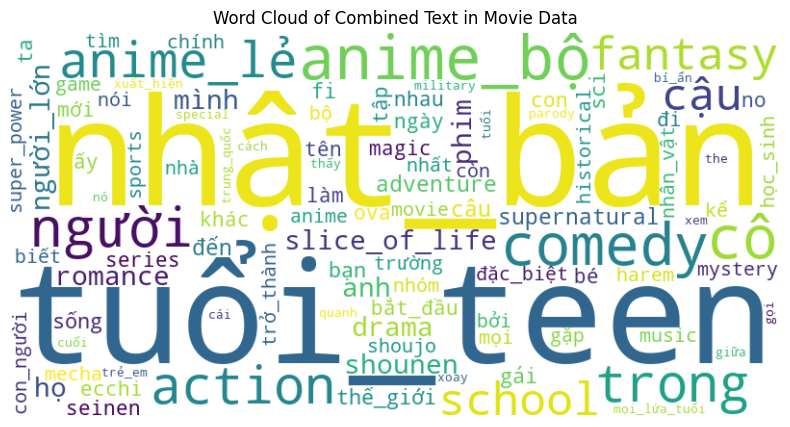

In [51]:
# Tạo TF-IDF Vectorizer 
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['combined_text'])

# Tính tổng TF-IDF cho mỗi từ sử dụng biểu diễn sparse
word_tfidf_sum = tfidf_matrix.sum(axis=0)

# Chuyển đổi kết quả thành một mảng numpy
word_tfidf_sum = np.array(word_tfidf_sum).flatten()

# Lấy danh sách từ vựng
feature_names = tfidf_vectorizer.get_feature_names_out()

# Tạo một dictionary từ feature names và tổng TF-IDF
word_freq_dict = dict(zip(feature_names, word_tfidf_sum))

# Tạo đối tượng WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate_from_frequencies(word_freq_dict)

# Trực quan hóa WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Combined Text in Movie Data')
plt.show()

Lưu vào Model.csv

In [47]:
# Lưu dữ liệu vào tệp CSV "Model.csv"
df.to_csv(r"D:\projects\Recommendation_Movie\Data_csv\Model.csv", index=False, encoding='utf-8-sig')
